**💡 핵심 클래스: ChatOllama**      
ChatOllama는 LangChain의 BaseChatModel을 상속한 클래스로, Ollama 서버에서 실행 중인 LLM을 사용하여 채팅 스타일의 응답을 생성합니다.

In [ ]:
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 모델 로드
llm = ChatOllama(model="exaone3.5:7.8b", temperature=0.7)

# 프롬프트 템플릿 설정 (선택 사항이지만 권장)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant."),
    ("user", "{input}")
])

# 출력 파서 설정 (LLM의 출력을 문자열로 파싱)
output_parser = StrOutputParser()

# 체인 구성
chain = prompt | llm | output_parser

# 답변 요청
question = "대한민국의 수도는 어디인가요?"
response = chain.invoke({"input": question})

# 답변 출력
print(f"질문: {question}")
print(f"답변: {response}")

##**ChatOllama 파라미터**

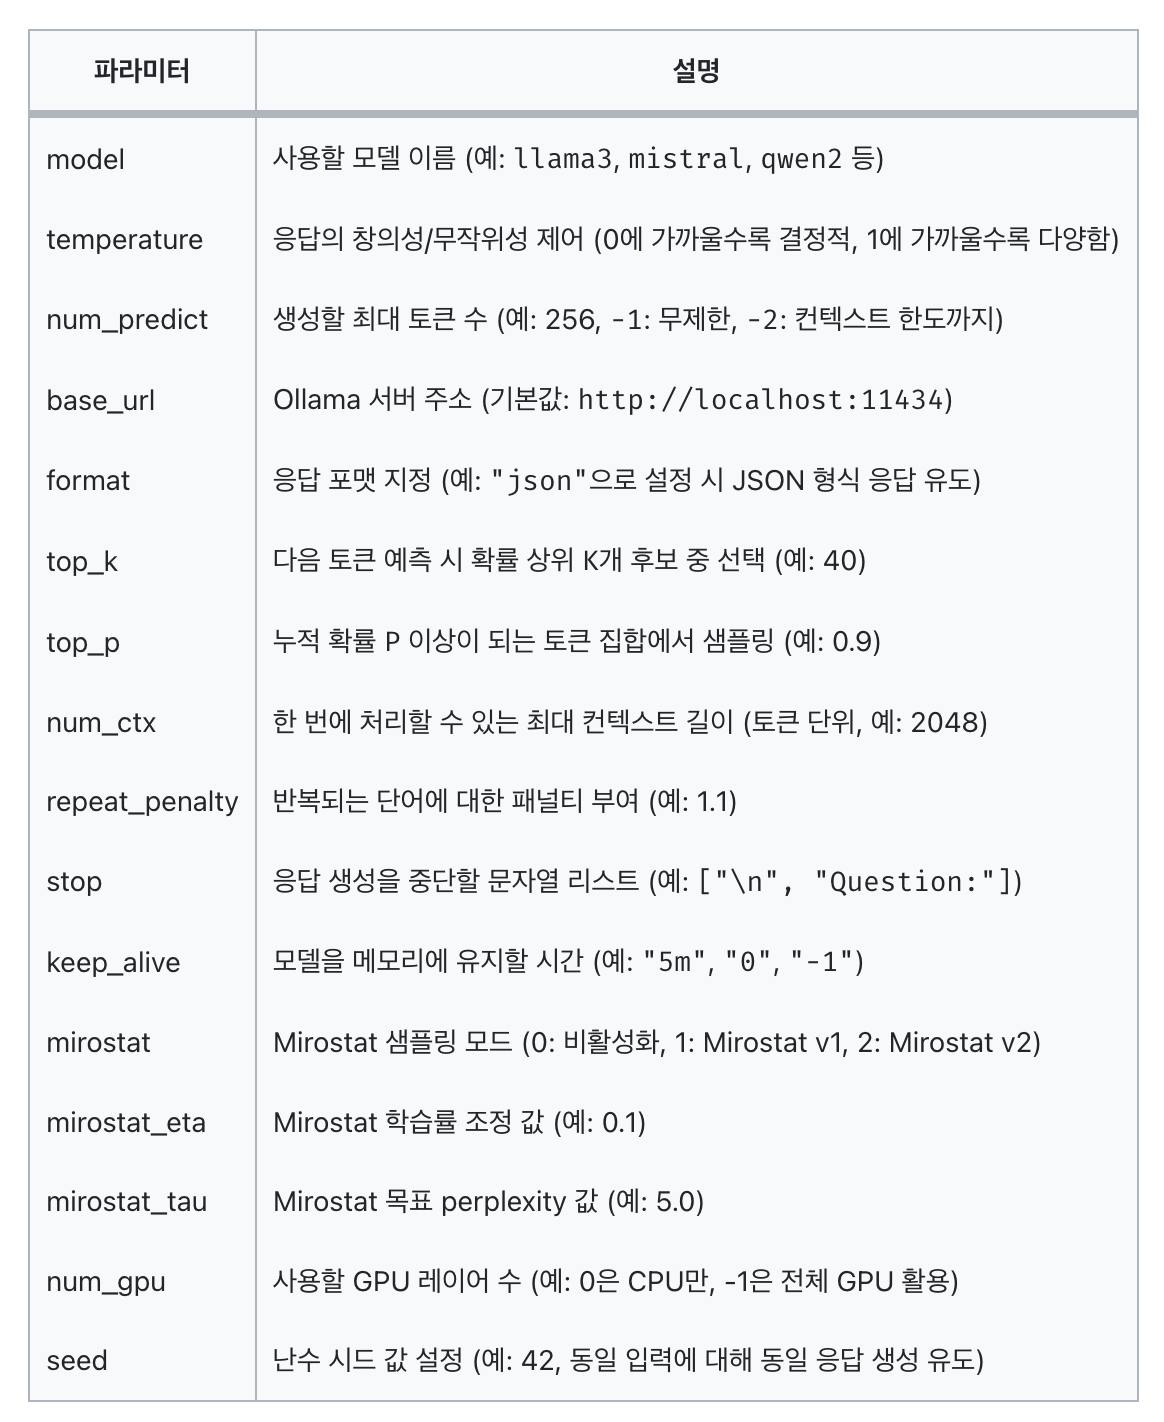

### 1. 💬 시스템 프롬프트 기반 번역기
ChatPromptTemplate을 통해 다양한 역할(system)을 설정한 프롬프트 템플릿을 사용할 수 있습니다.

In [5]:
from langchain_core.prompts import ChatPromptTemplate
# from langchain_community.chat_models import ChatOllama
from langchain_ollama import ChatOllama

# 1. 프롬프트 템플릿 정의
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a translator from English to Korean."),
    ("human", "{sentence}")
])

# 2. LLM 모델 정의 (exaone 기반)
llm = ChatOllama(model="exaone3.5:7.8b")

# 3. 체인 구성
chain = prompt | llm

# 4. 실행
result = chain.invoke({"sentence": "I love programming."})
print(result.content)

프로그래밍을 정말 사랑해요. (Jayeong programmingeul really saranghayo.) 

(Note: A slight adjustment for natural flow in Korean could be "프로그래밍을 정말 좋아해요." which translates more directly to "I really like programming.") 

So, a more commonly used expression would be:
**프로그래밍을 정말 좋아해요.**


### 2. 🖥️ .invoke() 함수 사용하기
LangChain의 .invoke() 메서드를 가장 단순하고 직관적으로 보여줍니다.

In [6]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="exaone3.5:7.8b")

response = llm.invoke("Where is the nearest train station in Kingston, London?")
print(response.content)

To find the nearest train station in Kingston upon Thames, London, you can visit local transport websites like Google Maps or the official Transport for London (TfL) website. Generally, some central locations in Kingston include:

1. **Kingston Railway Station** - Located near Kingston Bridge, it serves several major London rail lines including the Great Western Main Line and Southeastern lines.
2. **New Malden Railway Station** - Also quite close, it is convenient for accessing different lines via the Jubilee Line extension.

For precise directions and real-time updates, please use a mapping service or the TfL app, which can provide the exact nearest station based on your current location or specified address in Kingston.


### 3. 🛠️ Tool Calling 기능 (도구 자동 호출)
- @tool : 함수를 LangChain에서 사용 가능한 툴로 등록
- .bind_tools() : LLM에 도구 사용 권한 부여
- .invoke() : 유저 입력에 따라 LLM이 툴 사용 여부 판단
- response.tool_calls : LLM이 호출할 도구와 파라미터를 명시한 지시
- tool.invoke(args) : 도구를 수동 실행하여 실제 결과 생성

In [8]:
from langchain_core.tools import tool
from langchain_ollama import ChatOllama

@tool
def check_balance(account_id: int) -> str:
    """Check the balance of a bank account by its ID."""
    return f"Account {account_id} has $5,000."

llm = ChatOllama(model="llama3.1:8b").bind_tools([check_balance])

response = llm.invoke("Check the balance for account 1234.")

print("########################")
print(response.tool_calls)
print("########################")

# tool_calls만 있으면, LLM이 판단만 했다는 뜻 → 실제 실행은 우리가 직접
if response.tool_calls:
    for call in response.tool_calls:
        tool_name = call["name"]
        args = call["args"]

        # 여기서 실제 실행
        if tool_name == "check_balance":
            result = check_balance.invoke(args)
            print(f"✅ Tool 실행 결과: {result}")

########################
[{'name': 'check_balance', 'args': {'account_id': 1234}, 'id': 'bcc604b7-3d24-4d3c-a9a1-e14d1fe228b6', 'type': 'tool_call'}]
########################
✅ Tool 실행 결과: Account 1234 has $5,000.


[유저 입력]

  ↓

LLM 분석 → "도구가 필요해!"

  ↓

tool_calls 반환 (함수 이름 + 파라미터)

  ↓

개발자가 직접 tool 실행 (invoke)

  ↓

실행 결과 출력 or 후속 대화로 전달



### 4. 🧠 멀티 메시지 대화 (invoke(messages)) - langchain

대화 내용을 저장할 리스트 (chat_history)를 유지합니다.

매번 LLM을 호출할 때, 시스템 메시지와 함께 chat_history의 최근 N개 메시지, 그리고 현재 사용자의 새 메시지를 함께 전달합니다.

LLM의 응답도 chat_history에 추가하여 다음 대화에 활용합니다.

In [9]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_ollama import ChatOllama

# LLM 초기화
llm = ChatOllama(model="exaone3.5:7.8b")

# 1. 시스템 메시지 정의
system_message = SystemMessage(content="You are a helpful AI assistant who remembers the last few turns of our conversation.")

# 2. 대화 내용(Chat History)을 저장할 리스트
chat_history = []

# 3. LLM에 전달할 최근 메시지 개수 설정 (예: 최근 4개 메시지 = 2턴의 대화)
#    이 값을 조절하여 얼마나 많은 과거 대화를 LLM이 기억하게 할지 결정할 수 있습니다.
#    (시스템 메시지는 항상 포함되므로, 실제로는 이 개수 + 1개의 메시지가 전달됨)
MAX_HISTORY_MESSAGES = 4

print("AI Assistant: 안녕하세요! 대화를 시작해 보세요. (종료하려면 'quit'을 입력하세요)")

while True:
    user_input = input("나: ")
    if user_input.lower() == 'quit':
        print("AI Assistant: 대화를 종료합니다.")
        break

    current_human_message = HumanMessage(content=user_input)

    # 4. LLM에 전달할 메시지 리스트 구성
    messages_to_llm = [system_message] # 항상 시스템 메시지로 시작

    # 최근 대화 기록 추가 (가장 오래된 것부터 순서대로)
    # chat_history에서 최근 MAX_HISTORY_MESSAGES 개수만큼 가져옴
    recent_history = chat_history[-MAX_HISTORY_MESSAGES:]
    messages_to_llm.extend(recent_history)

    messages_to_llm.append(current_human_message) # 현재 사용자 메시지 추가

    # 디버깅: LLM에 전달되는 메시지 확인
    print("\n--- LLM에 전달되는 메시지 ---")
    for msg in messages_to_llm:
        print(f"{msg.type}: {msg.content}")
    print("---------------------------\n")

    # 5. LLM 호출
    ai_response = llm.invoke(messages_to_llm)

    print(f"AI Assistant: {ai_response.content}")

    # 6. 현재 사용자의 메시지와 AI의 응답을 chat_history에 추가
    chat_history.append(current_human_message)
    chat_history.append(ai_response) # AIMessage 객체 그대로 추가

    # (선택적) 너무 많은 히스토리가 쌓이는 것을 방지하기 위해 오래된 히스토리 제거
    # 예를 들어, chat_history의 최대 길이를 10개 메시지 (5턴)로 유지
    # MAX_TOTAL_HISTORY = 10
    # if len(chat_history) > MAX_TOTAL_HISTORY:
    #     chat_history = chat_history[-MAX_TOTAL_HISTORY:]

AI Assistant: 안녕하세요! 대화를 시작해 보세요. (종료하려면 'quit'을 입력하세요)

--- LLM에 전달되는 메시지 ---
system: You are a helpful AI assistant who remembers the last few turns of our conversation.
human: 안녕 나는 서린이야.
---------------------------

AI Assistant: 안녕하세요, 서린님! 만나서 반가워요. 어떤 도움이 필요하신지 말씀해 주세요. 어떻게 도와드릴 수 있을지 함께 고민해 볼게요.

--- LLM에 전달되는 메시지 ---
system: You are a helpful AI assistant who remembers the last few turns of our conversation.
human: 안녕 나는 서린이야.
ai: 안녕하세요, 서린님! 만나서 반가워요. 어떤 도움이 필요하신지 말씀해 주세요. 어떻게 도와드릴 수 있을지 함께 고민해 볼게요.
human: 너 이름이 뭐야?
---------------------------

AI Assistant: 저는 AI 어시스턴트입니다. 특정 이름을 가진 개인이 아니라, 다양한 사용자님들을 돕기 위해 설계된 지능형 프로그램이에요. 서린님께 어떤 도움이 필요하신지 더 자세히 알려주시겠어요?

--- LLM에 전달되는 메시지 ---
system: You are a helpful AI assistant who remembers the last few turns of our conversation.
human: 안녕 나는 서린이야.
ai: 안녕하세요, 서린님! 만나서 반가워요. 어떤 도움이 필요하신지 말씀해 주세요. 어떻게 도와드릴 수 있을지 함께 고민해 볼게요.
human: 너 이름이 뭐야?
ai: 저는 AI 어시스턴트입니다. 특정 이름을 가진 개인이 아니라, 다양한 사용자님들을 돕기 위해 설계된 지능형 프로그램이에요. 서린님께 어떤 도움이 필요하신지 더 자세히

### 5. 🌊 토큰 스트리밍 (동기 버전)

**streaming=True (LLM 초기화 시):**

작동 원리: ChatOllama(..., streaming=True)와 같이 LLM을 초기화할 때 streaming 옵션을 True로 설정하면, LLM에게 응답을 생성하는 즉시 작은 조각(chunk 또는 token) 단위로 보내달라고 요청하는 것입니다. LLM은 전체 응답이 완성될 때까지 기다리지 않고, 생성되는 부분부터 순차적으로 클라이언트에게 전달합니다.

**llm.stream()과의 관계:**

이 streaming=True 설정은 llm.stream() 메소드와 함께 사용될 때 의미가 있습니다. llm.stream()은 이렇게 스트리밍 방식으로 전달되는 응답 조각들을 순회할 수 있는 반복자(iterator)를 반환합니다. for chunk in llm.stream(...) 구문을 통해 각 조각을 실시간으로 받을 수 있습니다.

**print(..., flush=True) (출력 시):**

print() 함수의 flush 매개변수: 이것은 Python의 내장 print() 함수에 있는 옵션입니다. 기본적으로 flush=False입니다.
flush=True의 역할:
print(..., flush=True)를 사용하면, print 함수가 호출될 때마다 출력 버퍼의 내용을 즉시 강제로 비우고 해당 내용을 화면(또는 다른 출력 대상)으로 보내도록 합니다.
따라서 end=""와 함께 flush=True를 사용하면, 스트리밍으로 수신되는 각 텍스트 조각(chunk.content)이 print되는 즉시 화면에 나타나게 되어, 마치 타자 치듯이 실시간으로 텍스트가 표시되는 효과를 얻을 수 있습니다.

In [11]:
from langchain_community.chat_models import ChatOllama

# streaming=True로 LLM을 초기화합니다.
llm = ChatOllama(model="exaone3.5:7.8b", streaming=True)

print("AI가 이야기를 시작합니다...")
# llm.stream()을 사용하여 응답을 스트리밍으로 받습니다.
for chunk in llm.stream("Tell me a story about a fox and a cat."):
    # chunk.content에 현재 수신된 텍스트 조각이 들어있습니다.
    # end=""는 print 함수가 자동으로 줄바꿈하는 것을 방지합니다.
    # flush=True는 출력 버퍼를 즉시 비워 화면에 바로 표시되도록 합니다.
    print(chunk.content, end="", flush=True)
print("\n이야기 끝!")

AI가 이야기를 시작합니다...
Once upon a time, in a lush, verdant forest where sunlight danced through the canopy, there lived a clever fox named Finn and a graceful cat named Cassia. Finn had a reputation for his quick wits and sly tricks, often leading curious creatures astray with his playful taunts. Cassia, on the other hand, was known for her serene demeanor and elegant stealth, a master of the shadows with a heart full of kindness.

One crisp autumn morning, as golden leaves swirled around them, Finn found himself in a peculiar predicament. A hunter’s trap had snared his hind leg, binding him tightly with thick ropes. His usual agility seemed curtailed, leaving him vulnerable and frustrated. Nearby, Cassia was enjoying her morning nap under the warm glow of the sun, unaware of the commotion brewing nearby.

Noticing Finn’s distress from a distance, Cassia decided to help despite their oft-told rivalry. With gentle curiosity rather than predatory intent, she approached cautiously, her moveme